In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.utils import plot_model

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
!nvidia-smi

Thu Apr 22 14:59:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla M60           On   | 00000000:00:1E.0 Off |                    0 |
| N/A   41C    P0    39W / 150W |   3810MiB /  7618MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [5]:
base_dir = './pre'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
        rescale=1/255,    
#        rotation_range=40,
#        width_shift_range=0.1,
#        height_shift_range=0.1,
#        zoom_range=0.2,
#        horizontal_flip=True,
#        vertical_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(
     rescale=1/255
)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    validation_dir,
#     color_mode='grayscale',
    target_size=(150,150),
    batch_size=100,
    class_mode='categorical'
)

Found 15986 images belonging to 7 classes.
Found 3992 images belonging to 7 classes.
Found 2074 images belonging to 7 classes.


# 전이 학습

In [6]:
# pretrained network
model_base = ResNet101V2(include_top=False, 
                            weights='imagenet', input_shape=(150,150,3))
# model_base의 weight학습을 동결
model_base.trainable=False

model_base.summary()

Model: "resnet101v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 77, 77, 64)   0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [7]:
model = Sequential()

# pretrained network를 우리의 모델 앞에 추가
model.add(model_base)

model.add(Flatten())

model.add(Dropout(0.5))

model.add(Dense(7, activation='softmax'))

model.summary()

model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 5, 5, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dropout (Dropout)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 358407    
Total params: 42,984,967
Trainable params: 358,407
Non-trainable params: 42,626,560
_________________________________________________________________


# Fine Tuning

In [8]:
'''
model_base.trainable=True

# 상위 layer 동결해제
for layer in model_base.layers:
    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:
        layer.trainable=True
    else:
        layer.trainable=False

# learning_rate 더 작게 설정
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',
              metrics=['accuracy'])
'''

"\nmodel_base.trainable=True\n\n# 상위 layer 동결해제\nfor layer in model_base.layers:\n    if layer.name in ['top_conv','block7b_project_conv', 'block7b_se_expand', 'block7b_se_reduce']:\n        layer.trainable=True\n    else:\n        layer.trainable=False\n\n# learning_rate 더 작게 설정\nmodel.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy',\n              metrics=['accuracy'])\n"

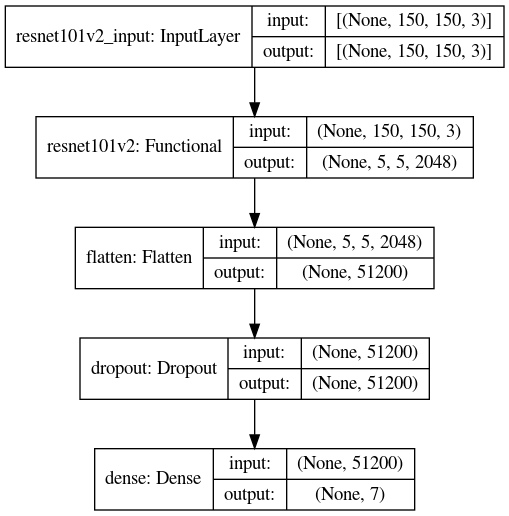

In [9]:
plot_model(model, show_shapes=True, rankdir='TB', dpi=96, 
           to_file='./models/ResNet101V2_1/ResNet101V2_1-1.png')

In [10]:
history = model.fit(train_generator, steps_per_epoch=159, epochs=20,
                    validation_data=validation_generator, validation_steps=39)

Epoch 1/20
159/159 [==============================] - 79s 450ms/step - loss: 3.2066 - accuracy: 0.2661 - val_loss: 1.8181 - val_accuracy: 0.4305
Epoch 2/20
159/159 [==============================] - 68s 430ms/step - loss: 2.1455 - accuracy: 0.4104 - val_loss: 1.6884 - val_accuracy: 0.4641
Epoch 3/20
159/159 [==============================] - 69s 431ms/step - loss: 1.7621 - accuracy: 0.4672 - val_loss: 1.6817 - val_accuracy: 0.4797
Epoch 4/20
159/159 [==============================] - 68s 430ms/step - loss: 1.4791 - accuracy: 0.5254 - val_loss: 1.6001 - val_accuracy: 0.4731
Epoch 5/20
159/159 [==============================] - 79s 497ms/step - loss: 1.2979 - accuracy: 0.5596 - val_loss: 1.5751 - val_accuracy: 0.4838
Epoch 6/20
159/159 [==============================] - 90s 564ms/step - loss: 1.1695 - accuracy: 0.5976 - val_loss: 1.5699 - val_accuracy: 0.4841
Epoch 7/20
159/159 [==============================] - 130s 817ms/step - loss: 1.0217 - accuracy: 0.6391 - val_loss: 1.6105 - val_a

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


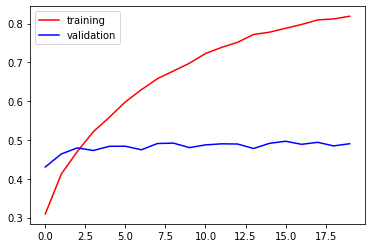

In [11]:
# history 객체 확인
print(history.history.keys())

train_acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']

train_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.plot(train_acc, color='r', label='training')
plt.plot(validation_acc, color='b', label='validation')
plt.legend()
plt.savefig('./models/ResNet101V2_1/ResNet101V2_1-1_acc.jpg')
plt.show()

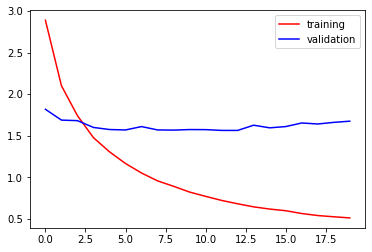

In [12]:
plt.plot(train_loss, color='r', label='training')
plt.plot(validation_loss, color='b', label='validation')
plt.legend()
plt.savefig('./models/ResNet101V2_1/ResNet101V2_1-1_val.jpg')
plt.show()

In [13]:
result = model.evaluate(test_generator)
print(np.round(result, 4))

21/21 [==============================] - 16s 737ms/step - loss: 1.5874 - accuracy: 0.5135
[1.5874 0.5135]


In [14]:
model.save('./models/ResNet101V2_1/ResNet101V2_1-1.h5')